# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn import mixture
from sklearn import preprocessing
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# Data Preprocess
### Reading data

In [2]:
def read_data(folder, step):
    file_path = "../data/50mph/" + str(folder) + "/" + str(folder) + str(step)

    data = pd.read_csv(file_path)
    
    return data
    

### Utility Functions

In [3]:
def match_partnum(df1, df2):
    diff1 = list(set(df1["part_num"]) - set(df2["part_num"]))
    diff2 = list(set(df2["part_num"]) - set(df1["part_num"]))
    
    del_row_idx1 = []
    del_row_idx2 = []
    for i in range(len(diff1)):
        del_row_idx1.append(int(np.where(df1["part_num"] == diff1[i])[0]))
    df1 = df1.drop(del_row_idx1, axis=0)

    for i in range(len(diff2)):
        del_row_idx2.append(int(np.where(df2["part_num"] == diff2[i])[0]))
    df2 = df2.drop(del_row_idx2, axis=0)

    # set dataframe index to part_num, otherwise there is a mismatch of index between 
    # df1 and df2 since index won't be reassigned when droping rows. Such mismatch leads
    # NaN values when calculating particle movement
#     df1 = df1.set_index(pd.Index(df1["part_num"]))
#     df2 = df2.set_index(pd.Index(df2["part_num"]))
    df1 = df1.set_index(pd.Index(range(len(df1["part_num"]))))
    df2 = df2.set_index(pd.Index(range(len(df2["part_num"]))))
#     print(range(len(df1["part_num"])))
#     print(range(len(df2["part_num"])))
    
    return df1, df2

def util_winsorization(df):
    p = 0.95
    quantile_value = np.quantile(df, p)
    
    df = df.apply(lambda x: x if x < quantile_value else quantile_value)
    
    return df

def preprocess(df):
    # change movement into absolute values
    df.iloc[:,4:7] = np.abs(df.iloc[:,4:7])

    # take natural logarithm for movement columns
    min_value = 1e-5
    df.iloc[:,4:7] = np.log(df.iloc[:,4:7] + min_value)
    
    # winsorization is not suitable here, it actually makes the clustering results worse
#     df.iloc[:,4:7] = df.iloc[:,4:7].apply(util_winsorization, axis = 0)
    
    # data standardization 
    tmp = pd.DataFrame(preprocessing.scale(df.iloc[:,4:7]))
    tmp = tmp.set_index(pd.Index(range(len(df["part_num"]))))
    tmp.columns = df.columns[4:7]
    df.iloc[:,4:7] = tmp
    
    return df

def cross_section(df, x_range=None, y_range=None, z_range=None):
    if x_range != None:
        df = df.loc[(df['x'] >= x_range[0]) & (df['x'] <= x_range[1])]
    if y_range != None:
        df = df.loc[(df['y'] >= x_range[0]) & (df['y'] <= x_range[1])]
    if z_range != None:
        df = df.loc[(df['z'] >= x_range[0]) & (df['z'] <= x_range[1])]
    
    return df
    
    

# Clustering
### Center Binding

In [4]:
# set folder name and file name
folder_init, folder_final = "cb_d9out", "cb_d16out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)
# print(init_state.head())
# print(final_state.head())
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]

# finalize particle movement dataframe
part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']
# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)
# part_movement
# print(max(part_movement['x']), min(part_movement['x']))
# print(max(part_movement['y']), min(part_movement['y']))
# print(max(part_movement['z']), min(part_movement['z']))

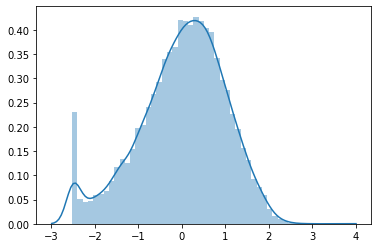

In [5]:
%matplotlib inline

# get a intuition of data distributions
sns.distplot(pd.DataFrame(part_movement["movement_z"]))


In [6]:
import visualization_util as vs

# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 4, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])
print(Counter(kmeans.labels_))
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('labels_movement_cb.csv',header=True, index=False)


1555
Counter({0: 4909, 1: 3539, 3: 1629, 2: 1349})


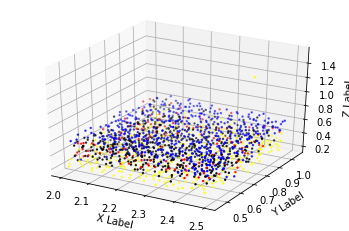

In [11]:
def plot_coordinate(data, label):
    color_map = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'black', 4: 'white',
                 5: 'green', 6: 'magenta', 7: 'cyan'}
    color = [color_map[labels] for labels in label ]
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1, projection = '3d')
    x, y, z = data["x"], data["y"], data["z"]
    ax.scatter(x, y, z, s = 2, c=color, marker='o')
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

x_range = [2, 2.5]

label = [label for row_idx, label in enumerate(kmeans.labels_) if row_idx in part_num.index.values]

part_num = cross_section(part_movement, x_range)
plot_coordinate(part_num, label)

In [128]:
import visualization_util as vs
x_range = [2, 2.5]
part_num = cross_section(part_movement, x_range)
print(len(part_num))
print(part_num.index.values)
label = [label for row_idx, label in enumerate(kmeans.labels_) if row_idx in part_num.index.values]
part_num


# save = pd.DataFrame({'part_num':part_num,'label':label})
# save.to_csv('labels_movement_cross_cb.csv',header=True, index=False)
# vs.plot('labels_movement_cross_cb.csv', 'CenterBinding.v3d','library.vlb')

1618
[   13    14    15 ... 11415 11424 11425]



13          14
14          15
15          16
17          18
18          19
52          53
53          54
54          55
55          56
56          57
89          90
90          91
91          92
92          93
93          94
94          95
128        129
129        130
130        131
131        132
132        133
166        167
167        168
168        169
169        170
170        171
203        204
204        205
205        206
206        207
         ...  
11320    11343
11333    11356
11334    11357
11335    11358
11336    11359
11347    11371
11348    11372
11349    11373
11350    11374
11351    11375
11363    11387
11364    11388
11365    11389
11379    11403
11380    11404
11381    11405
11382    11406
11383    11407
11396    11420
11397    11421
11398    11422
11399    11423
11400    11424
11411    11435
11412    11436
11413    11437
11414    11438
11415    11439
11424    11448
11425    11449
Name: part_num, Length: 1618, dtype: int64

In [7]:
import visualization_util as vs

vs.plot('labels_movement_cb.csv', 'CenterBinding.v3d','library.vlb')

Terminate program? 


SystemExit: 

/Users/bin/anaconda3/envs/research/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Full Support

In [13]:
# set folder name and file name
folder_init, folder_final = "fs_d7out", "fs_d14out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# print(list(set(init_state["part_num"]) - set(final_state["part_num"])))
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]
# finalize particle movement dataframe

part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)
# part_movement


In [14]:
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])
print(Counter(kmeans.labels_))
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('labels_movement_fs.csv',header=True, index=False)


Counter({0: 3740, 2: 2472, 4: 1633, 1: 1626, 3: 1148})


In [10]:
vs.plot('labels_movement_fs.csv', 'FullSup.v3d','library.vlb')

Terminate program? 


SystemExit: 

/Users/bin/anaconda3/envs/research/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Lack of Center Support

In [16]:
# set folder name and file name
folder_init, folder_final = "locs_d9out", "locs_d16out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# print(list(set(init_state["part_num"]) - set(final_state["part_num"])))
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]
# finalize particle movement dataframe

part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)
# part_movement


In [17]:
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])
print(Counter(kmeans.labels_))
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('labels_movement_locs.csv',header=True, index=False)


Counter({1: 4352, 2: 2094, 0: 1842, 4: 1679, 3: 1438})


In [22]:
vs.plot('labels_movement_locs.csv', 'LackofCenterSup.v3d','library.vlb')

Terminate program? 


SystemExit: 

/Users/bin/anaconda3/envs/research/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Lack of Rail Seat Support

In [19]:
# set folder name and file name
folder_init, folder_final = "lorss_d13out", "lorss_d20out"
step_init, step_final = "_Step1.csv", "_Step303.csv"

# read initial state file and final state file
init_state = read_data(folder_init, step_init)
final_state = read_data(folder_final, step_final)

# remove particles not exist in both files 
init_state, final_state = match_partnum(init_state, final_state)

# print(list(set(init_state["part_num"]) - set(final_state["part_num"])))
# calculate particle movement in x, y, z directions
part_movement = []
part_movement = final_state.iloc[:,2:5] - init_state.iloc[:,2:5]
# finalize particle movement dataframe

part_movement = pd.concat([final_state["part_num"].astype(int), final_state.iloc[:,2:5],
                           part_movement], axis=1)
part_movement.index.name = ""
part_movement.columns = ['part_num', 'x', 'y', 'z', 'movement_x', 'movement_y', 'movement_z']

# preprocess dataframe
# print(part_movement.iloc[:,:7])
part_movement = preprocess(part_movement)
# part_movement


In [20]:
# unsuperised kmeans clustering
kmeans = cluster.KMeans(n_clusters = 5, n_init = 10, random_state = 0).fit(part_movement.iloc[:,4:7])
print(Counter(kmeans.labels_))
label = pd.DataFrame({'part_num':part_movement["part_num"],'label':kmeans.labels_})
label.to_csv('labels_movement_lorss.csv',header=True, index=False)


Counter({4: 3883, 2: 2787, 1: 2191, 0: 1673, 3: 1243})


In [21]:
vs.plot('labels_movement_fs.csv', 'LackofRailSeatSup.v3d','library.vlb')

Terminate program? 


SystemExit: 

/Users/bin/anaconda3/envs/research/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
